In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from plot_config import *
from utils import *

In [3]:
rerun = False

In [4]:
if rerun:
    for name in ['domain4','domain_all']:
        if name == 'domain_all':
            print('all')
            ds = open_domain_all()
        else:
            print('4')
            ds = open_domain4()
        
        m = len(ds.space)
        n = len(ds.time)
        limit = 1825
        realigned = xr.Dataset()
        
        # %%time
        for var in ds.data_vars:
            if '_' in var and var not in ['dif_h','dif_v']:
                continue
            print(var, end =' ')
            array = xr.DataArray(np.zeros((n-limit,limit)), dims = ('time','space'))
            for i in range(limit):
                array[:,i] = ds[var][limit-i:n-i,i]
            realigned[var] = array
        realigned.to_zarr('/sciserver/filedb08-03/ocean/wenrui_temp/realigned_cov_'+name+'_N',mode = 'w')

In [5]:
if rerun:
    for name in ['domain4','domain_all']:
        ns = xr.open_zarr('/sciserver/filedb08-03/ocean/wenrui_temp/realigned_cov_'+name)
        for var in rhs_list+region_names+['sum']:
            ns[var] = ns[var].cumsum(dim = 'space')
        
        Y = ns['sl'][:,0]
        EY2 = float(np.mean(Y*Y))
        
        the_covs = xr.Dataset()
        for var in rhs_list+region_names+['sf','sum']:
            the_covs[var] = (ns[var]*Y).mean(dim = 'time')/EY2
        the_covs.to_zarr('lineplotprep/dense_covdata_'+name,mode = 'w')

In [6]:
# for name, (save1,save2) in [
#     ('domain_all',('figure10(c).png', 'figure10(d).png')),
#     ('domain4',('figure10(a).png', 'figure10(b).png')),
# ]:
def cov_plot(name,ax,region = False):
    if name == 'domain_all':
        NUMBER_OF_PARTICLE = NUMBER_OF_PARTICLE_domain_all
    else:
        NUMBER_OF_PARTICLE = NUMBER_OF_PARTICLE_domain4
    the_covs = xr.open_zarr('lineplotprep/dense_covdata_'+name)
    covs = {}
    for var in the_covs.data_vars:
        covs[var]= np.array(the_covs[var])
    bins = 1
    n = 9497
    m = 1825#len(ds.space)
    size = (n//bins, m//bins)
    xs = np.arange(0,size[1]*1+1,1)/365
    if not region:
        for var in rhs_list+['sf']:
            if var == 'sf':
                ax.plot(xs,[1]+list(covs[var]),label = 'Initial Salinity Anomaly',color = 'k')
            else:
                ax.plot(xs,[0]+list(-covs[var]/NUMBER_OF_PARTICLE),label = term_dic[var],color = color_dic_mean[var])
        ax.plot(xs,[0]+list(1-covs['sf']-(-covs['sum'])/NUMBER_OF_PARTICLE),color = error_color, label = 'Error')
        plt.ylim(-0.35,1.1)
        # plt.legend(fontsize = 7.5)
    
    else:
        total = np.zeros(len(covs['A'])+1)
        for var in region_names+['sf']:
            if var == 'sf':
                thing = np.array([1]+list(covs[var]))
                ax.plot(xs,thing,label = 'Initial Salinity Anomaly',color = 'k')
            else:
                thing = np.array([0]+list(-covs[var]/NUMBER_OF_PARTICLE))
                ax.plot(xs,thing,label = region_longnames[var],color = region_colors[var])
            total+=thing
        ax.plot(xs,1-total,color = 'r',ls = ':', label = 'Other Regions + Error')
        plt.ylim(-0.35,1.1)
        # plt.legend(fontsize = 7.5)
    return ax.get_legend_handles_labels()

In [7]:
mm = 1/25.4

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.38.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


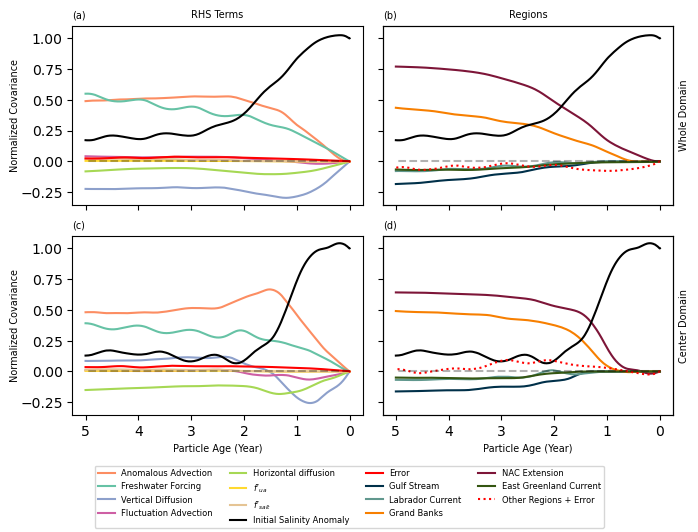

In [8]:
fig,axs = plt.subplots(2,2,sharex = True, sharey = True,figsize = (180*mm,135*mm))
handles = []
labels = []
for j,region in enumerate([False,True]):
    for i,where in enumerate(['domain_all','domain4']):
        ax = axs[i,j]
        if i==0 and j==0:
            ax.invert_xaxis()
        hd,lb = cov_plot(where,ax,region = region)
        if i==1:
            ax.set_xlabel('Particle Age (Year)',fontsize = 7)
        else:
            ax.set_title(['RHS Terms','Regions'][j],fontsize = 7)
            handles.extend(hd)
            labels.extend(lb)
        if j ==0:
            ax.set_ylabel('Normalized Covariance',fontsize = 7,labelpad = 0)
        else:
            ax2 = ax.twinx()
            ax2.set_ylabel(['Whole Domain','Center Domain'][i],fontsize = 7)
            ax2.set_yticks([])
axs = axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(f'({chr(97+i)})', loc = 'left',fontsize = 7)
    ax.plot([0,5],np.zeros(2),'k--',alpha = 0.3)
plt.tight_layout()
fig.subplots_adjust(bottom = 0.21)

unique = dict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h

# Final combined legend
fig.legend(unique.values(), unique.keys(),loc='lower center', ncol=4,fontsize = 6)
plt.savefig('covariance.pdf',dpi = 400)

In [9]:
# ds1 = open_domain_all()
# ds2 = open_domain4()

# ds1['A'][0,0].values

# ds2['A'][0,0].values

# name = 'domain_all'
# the_covs = xr.open_zarr('lineplotprep/dense_covdata_'+name)
# covs = {}
# for var in the_covs.data_vars:
#     covs[var]= np.array(the_covs[var])

# bins = 1
# n = 9497
# m = 1825#len(ds.space)
# size = (n//bins, m//bins)

# xs = np.arange(0,size[1]*50+1,50)/365
# for var in rhs_list+['sf']:
#     if var == 'sf':
#         plt.plot(xs,[1]+list(covs[var]),label = 'Initial Salinity Anomaly',color = 'k')
#     else:
#         plt.plot(xs,[0]+list(-covs[var]/NUMBER_OF_PARTICLE),label = term_dic[var],color = color_dic[var])
# plt.xlabel('Years Before')
# plt.ylabel(r'$\frac{EX_iY}{EY^2}$')
# plt.legend(fontsize = 8)